![alt text](https://qph.fs.quoracdn.net/main-qimg-d9198795d5d7aa4a164cf479fbb3a3d0)

<center>

# Natural Scenes Classification

In this presentation I going to explain how to build a image classifier from scratch using convolutional neural networks (CNNs). Let's dive in!


The agenda for the next 25 minites looks as follows:
1.   First I will explain my dataset and will visualize the dataset
2.   Then in a second step I will build, train and evaluate my first CNN model on the dataset I have


## Outline 

This presentation follows a basic machine learning workflow:

* **1. Examine and understand data** 
* **2. Build the model**
* **2. Train the model**
* **3. Test the model**
* **4. Improve the model and repeat the process**

## Importing the necessary libraries

In [115]:
import os
import cv2
import glob
import sklearn
import pathlib
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import random as rn
from os import path
import seaborn as sns
import tensorflow as tf
import scikitplot as skplt
from folder_structure import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.data.experimental import AUTOTUNE
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

The first thing I do :
*   how the data directories are structured.
*   what the labels are.
*   what some sample images look like.


In [116]:
#Setting up data directories
DATASET        = pathlib.Path('Data/')
train_data_dir = pathlib.Path('Data/train/')
valid_data_dir = pathlib.Path('Data/validation/')
test_data_dir  = pathlib.Path('Data/test/')

In [117]:
#Structure of the DATASET Folder
tree(DATASET,level=2, limit_to_directories=False)

Data
├── saved_models
│   ├── best_model.h5
│   ├── model_tuned_1.hdf5
│   └── model_tuned_2.hdf5
├── test
│   ├── buildings
│   ├── forest
│   ├── glacier
│   ├── mountain
│   ├── sea
│   └── street
├── train
│   ├── buildings
│   ├── forest
│   ├── glacier
│   ├── mountain
│   ├── sea
│   └── street
└── validation
    ├── buildings
    ├── forest
    ├── glacier
    ├── mountain
    ├── sea
    └── street

22 directories, 3 files


## Generate a Dataset

In [4]:
#Defining image properties 
batch_size = 32
img_height = 150
img_width = 150

#Creating test, train and validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

#Getting class names 
class_names    = train_ds.class_names

Found 14034 files belonging to 6 classes.
Found 1800 files belonging to 6 classes.
Found 1200 files belonging to 6 classes.


In [5]:
########################################### EXPLORE THE DATASET  ###########################################################
def sample_images(dir_path: Path):
    #Defining the image classes
    classes = class_names
    #We'll output images in a 6X4 configuration. 
    nrows=6
    ncols=4
    pic_index=0
    fig=plt.gcf()
    fig.set_size_inches(ncols*4,nrows*6)

    pic_index+=4
    next_a_pix = [os.path.join(dir_path+classes[0]+'/' ,fname) for fname in os.listdir(dir_path+classes[0]+'/')[pic_index-4:pic_index]]
    next_b_pix = [os.path.join(dir_path+classes[1]+'/' ,fname) for fname in os.listdir(dir_path+classes[1]+'/')[pic_index-4:pic_index]]
    next_c_pix = [os.path.join(dir_path+classes[2]+'/' ,fname) for fname in os.listdir(dir_path+classes[2]+'/')[pic_index-4:pic_index]]
    next_d_pix = [os.path.join(dir_path+classes[3]+'/' ,fname) for fname in os.listdir(dir_path+classes[3]+'/')[pic_index-4:pic_index]]
    next_e_pix = [os.path.join(dir_path+classes[4]+'/' ,fname) for fname in os.listdir(dir_path+classes[4]+'/')[pic_index-4:pic_index]]
    next_f_pix = [os.path.join(dir_path+classes[5]+'/' ,fname) for fname in os.listdir(dir_path+classes[5]+'/')[pic_index-4:pic_index]]

    j=0
    for i, img_path in enumerate(next_a_pix+next_b_pix+next_c_pix+next_d_pix+next_e_pix+next_f_pix):
        sp=plt.subplot(nrows,ncols,i+1)
        sp.axis('Off')
        img=mpimg.imread(img_path)
        plt.imshow(img)

        if i%4==0 and i>=4:
            j=j+1

        sp.title.set_text(classes[j])


    plt.show()

## Visualize the data
Here are the set of 24 images , 4 in each class of my training set

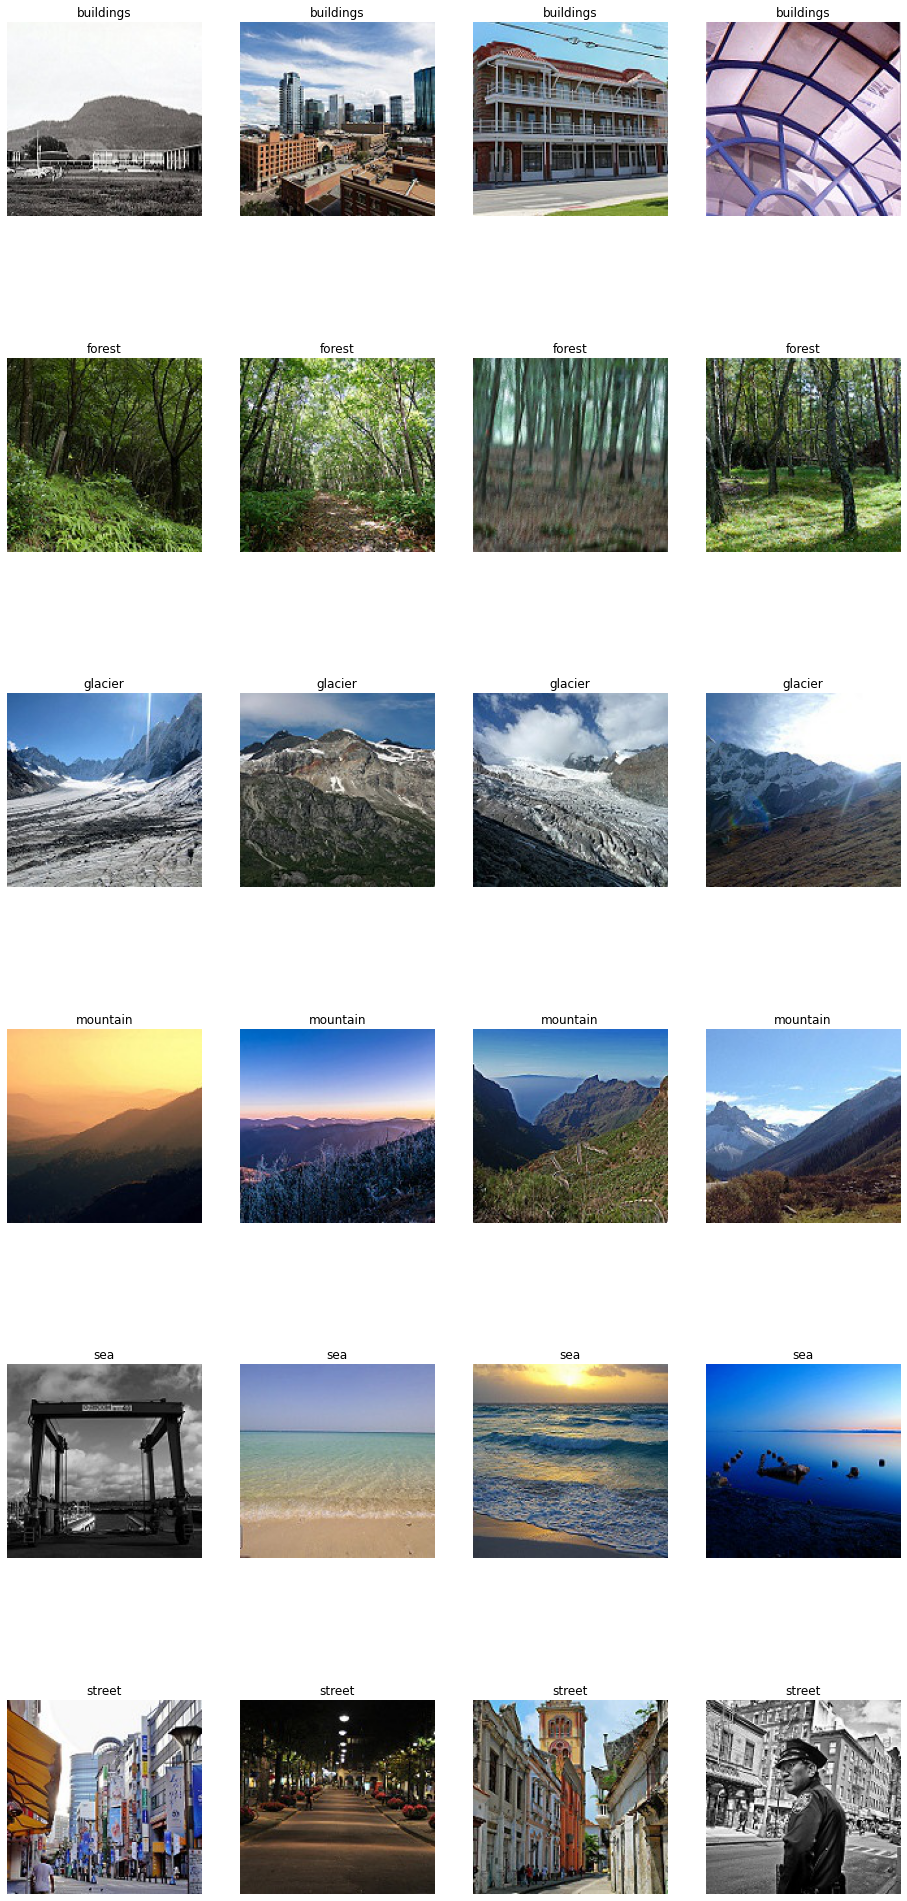

In [6]:
sample_images('Data/train/')

In [7]:
############################################ EXPLORE THE DATASET  #########################################################
def visulalize(dir_path : path):
    LABELS = os.listdir(dir_path)
    #plot class distributions of Train
    counts = {}
    for l in LABELS:
        counts[l] = len(os.listdir(os.path.join(dir_path, l)))
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(counts)), list(counts.values()), align='center')
    plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=80)
    plt.xlabel('class label', fontsize=13,)
    plt.ylabel('class size', fontsize=13)
    plt.title('Images in {} dataset'.format(str(dir_path)[5:-1]), fontsize=15);

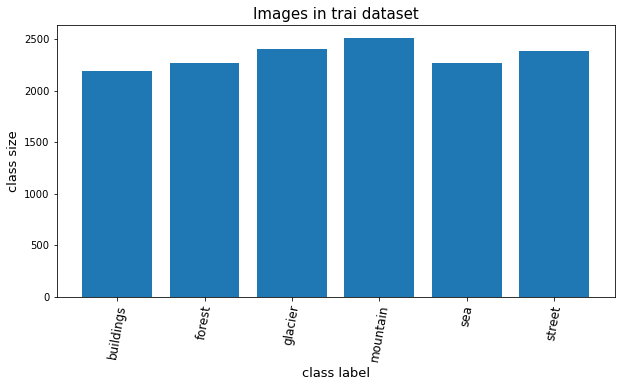

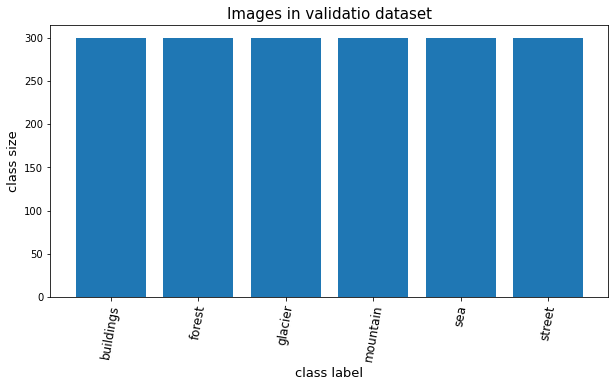

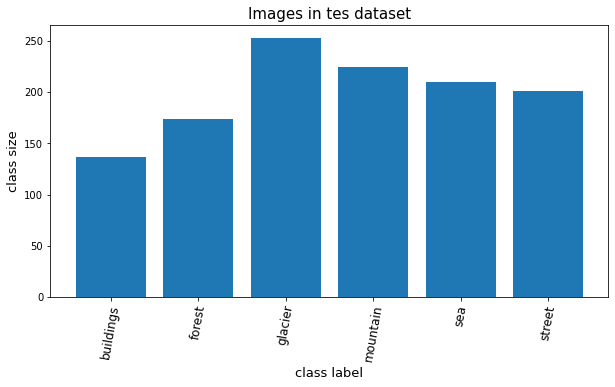

In [8]:
####################################### EXPLORE THE DATASET  ##############################################################
visulalize(train_data_dir)
visulalize(valid_data_dir)
visulalize(test_data_dir)

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


The ``image_batch`` is a tensor of the shape ``(32, 150, 150, 3)``. This is a batch of 32 images of shape ``150x150x3`` (the last dimension referes to color channels RGB). The ``label_batch`` is a tensor of the shape ``(32,),`` these are corresponding labels to the 32 images.

## Standardize the data
The RGB channel values are in the ``[0, 255]`` range. This is not ideal for a neural network; in general input values should be small. Here, I will standardize values to be in the ``[0, 1]`` by using a Rescaling layer and  applied it to the dataset by calling map:

In [10]:
normalization_layer = preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Configure the dataset for performance
Let's make sure to use buffered prefetching so data can be yield from disk without having I/O become blocking. There are two important methods to be  used when loading data.

``.cache()`` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the  model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

``.prefetch()`` overlaps data preprocessing and model execution while training.

In [11]:
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## About  CNN

A CNN processes an image by passing it through a **series of convolution layers** with *filters (Kernals)* and *Pooling*. In the end it is passed to a **fully connected layers (FC) and a Softmax function** is applied to classify an object with probabilistic values between 0 and 1. The below figure is a complete flow of CNN to process an input image and classifies the objects based on the image matrix values.

<center>

![alt text](https://miro.medium.com/max/2510/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)



The **reduction of parameters is essential** to make it possible to process images due to their massive size of the input vectors. 
>  If we would take a Multilayer Perceptron Neural Network for images with a dimension of 4K (3,840 x 2,160 pixels), the amount of trainable parameters would be crazy huge because each pixel value in each dimension would be taken as an input parameter to the NN. This would be computationally very intensive 

Therefore, role of the CNN is to reduce the images into a form which is easier to process, without losing features which are critical for getting a good prediction. 


Instead of processing the information about the whole image in one step, the **visual information is processed partly in so-called receptive fields**.

This architecture is analogous to that of the connectivity pattern of Neurons in the Human Brain. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field.  These fields overlap and hence cover the whole view field. 

<center>

<h2 align="center"></h2> <img src="https://neurdiness.files.wordpress.com/2018/05/fncom-08-00135-g001.jpg" , height=300>

</center>



#### Convolution Layer
> The first layer of a CNN is the **Convolution Layer**,  which **extracts high-level features** by sliding a filter over the input image. 



*   **Element-wise matrix multiplication** between filter and small squares of input data.
*   Result is a **feature map** / convolved feature
* Preserves the **relationship between pixels** -> spacial information


**Example:**

Here you can see an (5 × 5) input matrix from an image with a (3 × 3) filter kernel. The input matrix is multiplied element-wise by the filter kernel F and the results are summed up to the convolved feature output matrix.


<center>

<h2 align="center"></h2> <img src="https://miro.medium.com/max/536/1*MrGSULUtkXc0Ou07QouV8A.gif" , height=300>

</center>

The filter kernel's values are:

\begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
 
 ##### $Filters$
In image processing, there is a wide range of different filter kernel one could choose for convolution.



Each type of **filter kernel helps to extract different aspects or features from the input image**,


#####  $Multichannel Stride$ 
>**stride:** Distance between two consecutive positions of the filter kernel 

With e.g stride = 2 we would move the filters two pixel further at a time, till it parses the complete width. Moving on, it hops down to the beginning (left) of the image but two pixels lower than initially. From there the process repeats until the entire image is traversed.

 <center> <h2 align="center"></h2> <img src="https://miro.medium.com/max/2560/1*ciDgQEjViWLnCbmX-EeSrA.gif" > </center>
  In the case of images with **multiple channels** (e.g. RGB), element-wise matrix multiplication is performed in each channel with the corresponding kernel channel and all the results are summed with the bias to give us a squashed one-depth channel Convoluted Feature Output.
 

#####  $Padding$

Sometimes filter does not fit perfectly fit the input image. We have two options:
 

1.   **Zero-padding:** pad the corners of the picture with zeros so that it fits
2.   **Valid padding:** Drop the part of the image where the filter did not fit. 
3.   **Mirror padding:** The image is conceptually mirrored at the edges.




   <center> <h2 align="center"></h2> <img src="https://miro.medium.com/max/790/1*nYf_cUIHFEWU1JXGwnz-Ig.gif" > </center>



####  Pooling Layer

Similar to the Convolution Layer, the Pooling layer is responsible for reducing the spatial size of the Convolved Feature while retaining important information.

Advantages:
*   decrease the computational power required to process the data through dimensionality reduction.

*   extract dominant features which are rotational and positional invariant

There are several types of Pooling: 

**1.    Max Pooling** returns the maximum value from the portion of the image covered by the Kernel. 

**2.   Average Pooling** returns the average of all the values from the portion of the image covered by the Kernel.


   <center> <h2 align="center"></h2> <img src="https://miro.medium.com/max/1204/1*SmiydxM5lbTjoKWYPiuzWQ.png" > </center>




####  Fully Connected Layers

<center> <h2 align="center"></h2> <img src="https://miro.medium.com/max/1108/1*Mw6LKUG8AWQhG73H1caT8w.png" > </center>

1.   **(flattened) Input Layer:** The Multilayer Perceptron (MLP) only takes vectors as inputs so we have to arrange our 3D the feature map matrix into a 1D vector by flattening it.

2. **Output Layer:** Here we use an activation function like softmax or sigmoid to map to each class a probability between 0 and 1.

3. **Connections and weights:** The network consists of connections. Fully connected means that each neuron in a layer has a connection transferring its output as an input into every neuron of the next layer. Each of these connections has a weight.

2.  **Activations:** Activations in one layer determine the activations of neurons in the next layer. The hidden layers usually have ReLu activation while the output layer has a softmax or sigmoid function.

2. **Weights:** Each Neuron takes as input the weighted sum of all outputs of the activated neurons of the previous layer.  These weights need to be adapted while training. 



<center> <h2 align="center"></h2> <img src="https://miro.medium.com/max/3840/1*5K-1CSOB2mb5Jn2L8K3f9Q.gif" > </center>


## Understanding the Convolution Equations

Here's our 3×3 pixel image, with each pixel labeled with a letter:

<img alt="The image" src="https://miro.medium.com/max/75/1*7zVtk9Xb3X6aQScJqxCUYw.png">

And here's our kernel, with each weight labeled with a Greek letter:

<img alt="The kernel" src="https://miro.medium.com/max/51/1*aCBPCSInHE6vFaECSAT5oA.png">

Since the filter fits in the image four times, we have four results:

<img alt="The activations" width="52" src="https://miro.medium.com/max/53/1*I8BERkXPnVjdVCawr7Q23A.png">

Here’s how we applied the filter to each section of the image to yield each result

<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="https://miro.medium.com/max/362/1*s-TmnXo69mAKbnMoMBnpMg.png">

The equation view is :

<img alt="The equation" width="436" caption="The equation" id="eq_view" src="https://miro.medium.com/max/428/1*-TnNZ4srYItcGXov-dTmmw.png">


Notice that the bias term, b, is the same for each section of the image. You can consider the bias as part of the filter, just like the weights (α, β, γ, δ) are part of the filter.


Here's an interesting insight—a convolution can be represented as a special kind of matrix multiplication. The weight matrix is just like the ones from traditional neural networks. However, this weight matrix has two special properties:

1. The zeros shown in gray are untrainable. This means that they’ll stay zero throughout the optimization process.
1. Some of the weights are equal, and while they are trainable (i.e., changeable), they must remain equal. These are called *shared weights*.

The zeros correspond to the pixels that the filter can't touch. Each row of the weight matrix corresponds to one application of the filter.

<img alt="Convolution as matrix multiplication" width="683" caption="Convolution as matrix multiplication" id="conv_matmul" src="https://miro.medium.com/max/700/1*95lL-PY5WEeBAtfaWAIIRQ.png">

## Making a basic model
The model consists of four convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. 

This model has not been tuned in any way - the goal is to understand the mechanics using the datasets I just created. 

In [15]:

def untuned_Model():
    model=tf.keras.models.Sequential([
            preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(32, 3, activation='relu'),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(64, 3, activation='relu'),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(128, 3, activation='relu'),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(256, 3, activation='relu'),
            layers.MaxPooling2D(2,2),


            layers.Flatten(),
            layers.Dense(128,activation='relu')
            layers.Dense(6,activation='softmax')
        ])
    return model

In [17]:
model = untuned_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

In [18]:
########################################Model Compilation##################################################################

model.compile(
  optimizer= 'adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [19]:
########################################Training the model#################################################################

def train_model(model):
    history = model.fit(train_ds, 
                        validation_data= val_ds,
                        epochs=100)
    return history

In [20]:
########################################Training the model#################################################################

history = train_model(model)

Epoch 1/100
439/439 [==============================] - 11s 26ms/step - loss: 1.5599 - accuracy: 0.4741 - val_loss: 1.5089 - val_accuracy: 0.5228
Epoch 2/100
439/439 [==============================] - 6s 15ms/step - loss: 1.4528 - accuracy: 0.5834 - val_loss: 1.4173 - val_accuracy: 0.6222
Epoch 3/100
439/439 [==============================] - 6s 15ms/step - loss: 1.3827 - accuracy: 0.6560 - val_loss: 1.3816 - val_accuracy: 0.6567
Epoch 4/100
439/439 [==============================] - 6s 15ms/step - loss: 1.3185 - accuracy: 0.7214 - val_loss: 1.2993 - val_accuracy: 0.7433
Epoch 5/100
439/439 [==============================] - 6s 15ms/step - loss: 1.3015 - accuracy: 0.7391 - val_loss: 1.3124 - val_accuracy: 0.7267
Epoch 6/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2803 - accuracy: 0.7618 - val_loss: 1.2975 - val_accuracy: 0.7439
Epoch 7/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2710 - accuracy: 0.7702 - val_loss: 1.2906 - val_accuracy

439/439 [==============================] - 6s 15ms/step - loss: 1.1920 - accuracy: 0.8511 - val_loss: 1.2382 - val_accuracy: 0.8044
Epoch 58/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2011 - accuracy: 0.8422 - val_loss: 1.2313 - val_accuracy: 0.8122
Epoch 59/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2023 - accuracy: 0.8410 - val_loss: 1.2531 - val_accuracy: 0.7900
Epoch 60/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2185 - accuracy: 0.8252 - val_loss: 1.2777 - val_accuracy: 0.7656
Epoch 61/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2003 - accuracy: 0.8430 - val_loss: 1.3167 - val_accuracy: 0.7267
Epoch 62/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2184 - accuracy: 0.8251 - val_loss: 1.2272 - val_accuracy: 0.8161
Epoch 63/100
439/439 [==============================] - 6s 15ms/step - loss: 1.2157 - accuracy: 0.8276 - val_loss: 1.3527 - val_accuracy: 0.690

## Visualize training results
Create plots of loss and accuracy on the training and validation sets.

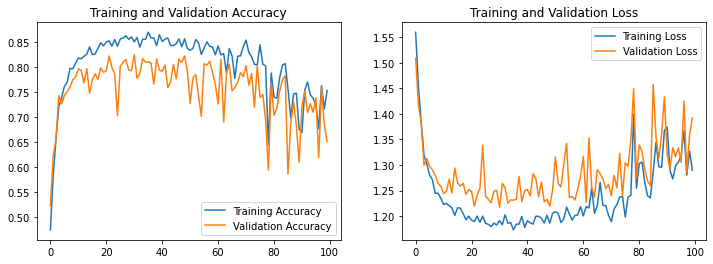

In [24]:
def visualize_result(history, epoch=int):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epoch)

    plt.figure(figsize=(18, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()

visualize_result(history, 100)

## Data augmentation

Having a large dataset is crucial for the performance of the deep learning model.Overfitting generally occurs because of having small number of training examples. Data augmentation  enables us  to **significantly increase the diversity of data available for training models, without actually collecting new data**. 

Data augmentation techniques like
*   cropping
*   rescale
*   rotating
*   horizontal flipping
are commonly used to train large neural networks.

First I will implement data augmentation using experimental Keras Preprocessing Layers first. These can be included inside the model like other layers, and run on the GPU.

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    preprocessing.RandomFlip("horizontal", 
                             input_shape=(img_height, 
                                          img_width,
                                          3)),
    preprocessing.RandomFlip("vertical", 
                             input_shape=(img_height, 
                                          img_width,
                                          3)),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomCrop(img_height,img_width),

  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

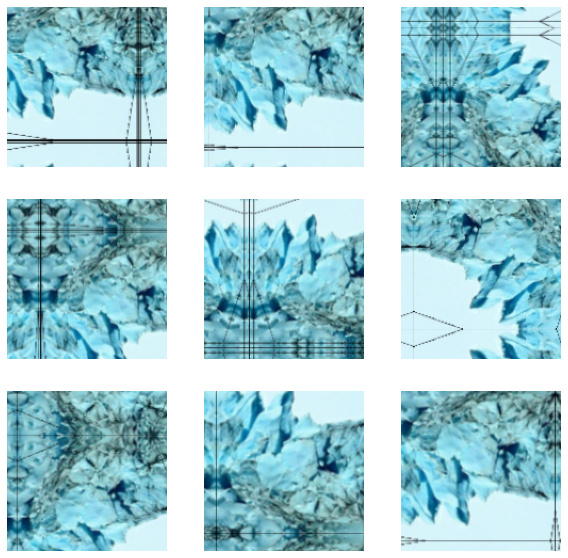

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model Building

Now we're ready to set up the architecture of the CNN. We're going to use:

*   **Input Layer:** As our images have shape 150 x 150 x 3, the first Convolution Layer is initialized with this input shape.

*   **10 Convolution Layers** with multiple different filters and filter sizes as well as zero padding and a ReLu Activation Function.
*   **5 Pooling Layers** with max pooling.
*   **Flattening** to make a vector out of the feature array.
*   **5 Fully Connected Layers** with 256, 128, 64, 32 and 16 neurons.
*   **Output Layer:** A softmax activation function maps class probabilities between 0 and 1 to each of the five classes.

What we also add  but didn't discuss before:

*   **BatchNormalization:** 'Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

*   **Dropout:** Dropout is a technique used to prevent a model from overfitting.  it randomly drops out number of output units from the applied layer during the training process. 

*   **Dense layer:** A dense layer is just a fully connected neural network layer. Each neuron recieves input from all the neurons in the previous layer, thus densely connected.






In [121]:
from tensorflow.keras.regularizers import L1,L2
def tuned_model_glob():
    model1=tf.keras.models.Sequential([
            data_augmentation,
            preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(16, 3, activation='relu'),
            tf.keras.layers.Conv2D(16, 3, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.Conv2D(32 ,3 ,activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(128, 3, activation='relu'),
            tf.keras.layers.Conv2D(128, 3, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Conv2D(256, 3, activation='relu',padding='same'),
            tf.keras.layers.Conv2D(256, 3, activation='relu',padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.4),
   
            tf.keras.layers.Flatten(),
            
            layers.Dense(256,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.Dense(128,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.Dense(64,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.Dense(32,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.Dense(16,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
        
            tf.keras.layers.Dense(6,activation='softmax',
                                 )
        ])
    return model1

model_glob = tuned_model_glob()
model_glob.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_16 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 146, 146, 16)      2320      
_________________________________________________________________
batch_normalization_115 (Bat (None, 146, 146, 16)      64        
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 73, 73, 16)      

In [125]:
def train_model(model):
    checkpointer = ModelCheckpoint(filepath='Data/saved_models/model_tuned_1.hdf5',monitor='val_loss')
    history = model.fit(train_ds,
                        epochs=500,
                        validation_data=val_ds,
                        batch_size=batch_size, 
                        callbacks=[checkpointer])
    return history

In [126]:
model_glob.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = train_model(model_glob)

Epoch 1/500
220/220 [==============================] - 11s 49ms/step - loss: 1.9440 - accuracy: 0.2624 - val_loss: 1.9585 - val_accuracy: 0.1667
Epoch 2/500
220/220 [==============================] - 10s 48ms/step - loss: 1.7561 - accuracy: 0.4193 - val_loss: 1.7999 - val_accuracy: 0.2989
Epoch 3/500
220/220 [==============================] - 10s 48ms/step - loss: 1.6696 - accuracy: 0.4714 - val_loss: 1.6352 - val_accuracy: 0.4844
Epoch 4/500
220/220 [==============================] - 10s 48ms/step - loss: 1.6287 - accuracy: 0.4978 - val_loss: 1.6120 - val_accuracy: 0.4867
Epoch 5/500
220/220 [==============================] - 10s 48ms/step - loss: 1.6103 - accuracy: 0.5062 - val_loss: 1.6019 - val_accuracy: 0.4878
Epoch 6/500
220/220 [==============================] - 10s 48ms/step - loss: 1.6117 - accuracy: 0.5006 - val_loss: 1.7162 - val_accuracy: 0.3483
Epoch 7/500
220/220 [==============================] - 10s 48ms/step - loss: 1.5976 - accuracy: 0.5114 - val_loss: 1.6887 - val_ac

220/220 [==============================] - 10s 48ms/step - loss: 1.4315 - accuracy: 0.6467 - val_loss: 1.4508 - val_accuracy: 0.6161
Epoch 58/500
220/220 [==============================] - 10s 47ms/step - loss: 1.4345 - accuracy: 0.6461 - val_loss: 1.4737 - val_accuracy: 0.5950
Epoch 59/500
220/220 [==============================] - 10s 47ms/step - loss: 1.4350 - accuracy: 0.6439 - val_loss: 1.4663 - val_accuracy: 0.5978
Epoch 60/500
220/220 [==============================] - 10s 47ms/step - loss: 1.4297 - accuracy: 0.6491 - val_loss: 1.4427 - val_accuracy: 0.6217
Epoch 61/500
220/220 [==============================] - 10s 47ms/step - loss: 1.4360 - accuracy: 0.6423 - val_loss: 1.3934 - val_accuracy: 0.6733
Epoch 62/500
220/220 [==============================] - 11s 48ms/step - loss: 1.4350 - accuracy: 0.6458 - val_loss: 1.6590 - val_accuracy: 0.4039
Epoch 63/500
220/220 [==============================] - 10s 48ms/step - loss: 1.4375 - accuracy: 0.6391 - val_loss: 1.4460 - val_accuracy

220/220 [==============================] - 10s 47ms/step - loss: 1.3955 - accuracy: 0.6724 - val_loss: 1.4270 - val_accuracy: 0.6361
Epoch 114/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3945 - accuracy: 0.6738 - val_loss: 1.5294 - val_accuracy: 0.5311
Epoch 115/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3923 - accuracy: 0.6764 - val_loss: 1.4445 - val_accuracy: 0.6161
Epoch 116/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3910 - accuracy: 0.6773 - val_loss: 1.3983 - val_accuracy: 0.6633
Epoch 117/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3978 - accuracy: 0.6705 - val_loss: 1.4369 - val_accuracy: 0.6233
Epoch 118/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3952 - accuracy: 0.6734 - val_loss: 1.4299 - val_accuracy: 0.6289
Epoch 119/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3972 - accuracy: 0.6713 - val_loss: 1.4734 - val_ac

Epoch 169/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3839 - accuracy: 0.6806 - val_loss: 1.3602 - val_accuracy: 0.6978
Epoch 170/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3791 - accuracy: 0.6849 - val_loss: 1.3635 - val_accuracy: 0.6944
Epoch 171/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3791 - accuracy: 0.6850 - val_loss: 1.4959 - val_accuracy: 0.5611
Epoch 172/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3807 - accuracy: 0.6844 - val_loss: 1.3687 - val_accuracy: 0.6889
Epoch 173/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3792 - accuracy: 0.6857 - val_loss: 1.3715 - val_accuracy: 0.6867
Epoch 174/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3769 - accuracy: 0.6882 - val_loss: 1.3911 - val_accuracy: 0.6683
Epoch 175/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3807 - accuracy: 0.6833 - val_loss: 1

Epoch 225/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3753 - accuracy: 0.6864 - val_loss: 1.4175 - val_accuracy: 0.6372
Epoch 226/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3746 - accuracy: 0.6875 - val_loss: 1.4228 - val_accuracy: 0.6322
Epoch 227/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3711 - accuracy: 0.6905 - val_loss: 1.4496 - val_accuracy: 0.6056
Epoch 228/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3737 - accuracy: 0.6870 - val_loss: 1.4762 - val_accuracy: 0.5800
Epoch 229/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3690 - accuracy: 0.6922 - val_loss: 1.3920 - val_accuracy: 0.6628
Epoch 230/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3658 - accuracy: 0.6958 - val_loss: 1.4576 - val_accuracy: 0.5972
Epoch 231/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3643 - accuracy: 0.6969 - val_loss: 1

Epoch 281/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3623 - accuracy: 0.6973 - val_loss: 1.3709 - val_accuracy: 0.6839
Epoch 282/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3578 - accuracy: 0.7021 - val_loss: 1.4306 - val_accuracy: 0.6244
Epoch 283/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3575 - accuracy: 0.7019 - val_loss: 1.3856 - val_accuracy: 0.6689
Epoch 284/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3616 - accuracy: 0.6973 - val_loss: 1.3778 - val_accuracy: 0.6783
Epoch 285/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3656 - accuracy: 0.6947 - val_loss: 1.3867 - val_accuracy: 0.6667
Epoch 286/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3611 - accuracy: 0.6998 - val_loss: 1.3816 - val_accuracy: 0.6706
Epoch 287/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3553 - accuracy: 0.7054 - val_loss: 1

Epoch 337/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3540 - accuracy: 0.7062 - val_loss: 1.3795 - val_accuracy: 0.6750
Epoch 338/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3583 - accuracy: 0.7017 - val_loss: 1.3615 - val_accuracy: 0.6939
Epoch 339/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3515 - accuracy: 0.7081 - val_loss: 1.4382 - val_accuracy: 0.6172
Epoch 340/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3586 - accuracy: 0.7015 - val_loss: 1.4075 - val_accuracy: 0.6483
Epoch 341/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3528 - accuracy: 0.7065 - val_loss: 1.3715 - val_accuracy: 0.6833
Epoch 342/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3493 - accuracy: 0.7108 - val_loss: 1.4155 - val_accuracy: 0.6372
Epoch 343/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3518 - accuracy: 0.7076 - val_loss: 1

Epoch 393/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3439 - accuracy: 0.7141 - val_loss: 1.3672 - val_accuracy: 0.6872
Epoch 394/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3536 - accuracy: 0.7046 - val_loss: 1.3653 - val_accuracy: 0.6883
Epoch 395/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3490 - accuracy: 0.7094 - val_loss: 1.3730 - val_accuracy: 0.6806
Epoch 396/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3474 - accuracy: 0.7116 - val_loss: 1.4283 - val_accuracy: 0.6261
Epoch 397/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3521 - accuracy: 0.7050 - val_loss: 1.3728 - val_accuracy: 0.6800
Epoch 398/500
220/220 [==============================] - 11s 48ms/step - loss: 1.3515 - accuracy: 0.7061 - val_loss: 1.4215 - val_accuracy: 0.6317
Epoch 399/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3499 - accuracy: 0.7082 - val_loss: 1

Epoch 449/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3375 - accuracy: 0.7208 - val_loss: 1.3635 - val_accuracy: 0.6906
Epoch 450/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3465 - accuracy: 0.7106 - val_loss: 1.5100 - val_accuracy: 0.5461
Epoch 451/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3470 - accuracy: 0.7111 - val_loss: 1.3783 - val_accuracy: 0.6744
Epoch 452/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3394 - accuracy: 0.7182 - val_loss: 1.3849 - val_accuracy: 0.6706
Epoch 453/500
220/220 [==============================] - 10s 47ms/step - loss: 1.3435 - accuracy: 0.7146 - val_loss: 1.3769 - val_accuracy: 0.6750
Epoch 454/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3392 - accuracy: 0.7183 - val_loss: 1.3586 - val_accuracy: 0.6939
Epoch 455/500
220/220 [==============================] - 10s 48ms/step - loss: 1.3421 - accuracy: 0.7152 - val_loss: 1

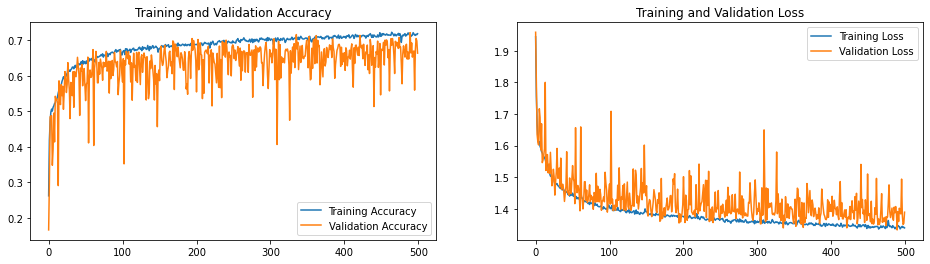

In [130]:
visualize_result(history, 500)

### Tuning model with new augmented data

Here I will implement this by using ImageDataGenerator class from Keras. We pass different transformation to the data set and it will do the necessary transformation during training process to see if the experimental preprocession under perform this tecnique 

**Normalization:** The ImageDataGenerator class can be used to rescale *pixel values from the range of 0-255 to the range 0-1 preferred for neural network models*. Scaling data to the range of 0-1 is traditionally referred to as normalization.


In [119]:
#Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.1)


train_generator=train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209
    
)

validation_generator=train_datagen.flow_from_directory(
      valid_data_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
    
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse',
    seed=2209,
    shuffle=False
) 


Found 14034 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


In [9]:
def model_final():
    model1=tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
        tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(3,3),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
        tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),


        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(6,activation='softmax')
    ])
    return model1

In [10]:
model_tuned_final = model_final()
model_tuned_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 16)      2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 146, 146, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 44, 44, 32)       

In [15]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.7, epsilon=1e-07, centered=False,
    name='RMSprop'
)
model_tuned_final.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


history2=model_tuned_final.fit(
    train_generator,
    steps_per_epoch=int(14034/64),
    epochs=100,
    workers=6,
    validation_data=validation_generator,
    validation_steps=int(1800/64),
    callbacks=[reduce],
    verbose=1
)

Epoch 1/100
219/219 [==============================] - 23s 106ms/step - loss: 1.1128 - accuracy: 0.5354 - val_loss: 2.1621 - val_accuracy: 0.2807
Epoch 2/100
219/219 [==============================] - 23s 104ms/step - loss: 1.0227 - accuracy: 0.5871 - val_loss: 1.1814 - val_accuracy: 0.5084
Epoch 3/100
219/219 [==============================] - 23s 104ms/step - loss: 0.9508 - accuracy: 0.6269 - val_loss: 2.0974 - val_accuracy: 0.3856
Epoch 4/100
219/219 [==============================] - 23s 104ms/step - loss: 0.9046 - accuracy: 0.6520 - val_loss: 1.2631 - val_accuracy: 0.4922
Epoch 5/100
219/219 [==============================] - 23s 104ms/step - loss: 0.8632 - accuracy: 0.6836 - val_loss: 1.3434 - val_accuracy: 0.5714
Epoch 6/100
219/219 [==============================] - 23s 104ms/step - loss: 0.8084 - accuracy: 0.7213 - val_loss: 1.0234 - val_accuracy: 0.6456
Epoch 7/100
219/219 [==============================] - 23s 105ms/step - loss: 0.7661 - accuracy: 0.7451 - val_loss: 0.8853 -

Epoch 57/100
219/219 [==============================] - 23s 103ms/step - loss: 0.3253 - accuracy: 0.9020 - val_loss: 0.3450 - val_accuracy: 0.8890
Epoch 58/100
219/219 [==============================] - 23s 104ms/step - loss: 0.3192 - accuracy: 0.9056 - val_loss: 0.3476 - val_accuracy: 0.8923
Epoch 59/100
219/219 [==============================] - 23s 104ms/step - loss: 0.3190 - accuracy: 0.9044 - val_loss: 0.3365 - val_accuracy: 0.8856
Epoch 60/100
219/219 [==============================] - 23s 104ms/step - loss: 0.3221 - accuracy: 0.9042 - val_loss: 0.3404 - val_accuracy: 0.8884
Epoch 61/100
219/219 [==============================] - 23s 104ms/step - loss: 0.3202 - accuracy: 0.9059 - val_loss: 0.3316 - val_accuracy: 0.8906
Epoch 62/100
219/219 [==============================] - 23s 104ms/step - loss: 0.3220 - accuracy: 0.9037 - val_loss: 0.3374 - val_accuracy: 0.8867
Epoch 63/100
219/219 [==============================] - 23s 104ms/step - loss: 0.3301 - accuracy: 0.9012 - val_loss: 0

In [18]:
model_tuned_final.save('my_model.h5')

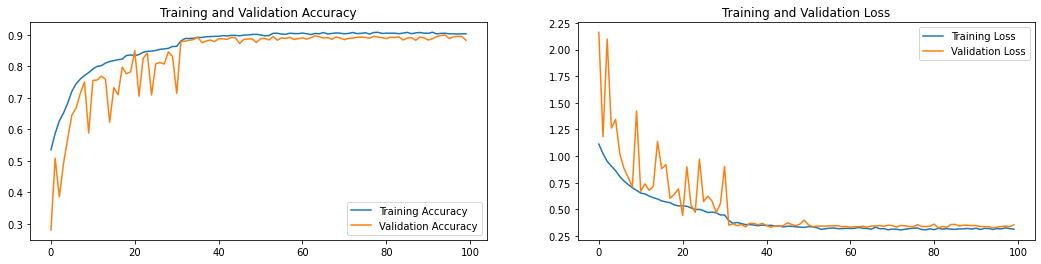

In [29]:
visualize_result(history2,100)

So we can see that the training accuracy and validation accuracy are increasing over time. Also the difference between training and validation accuracy is not that significant. 

In [103]:
# Evaluate model
evaluated = model_tuned_final.evaluate(validation_generator)
print(f'Best model loss: {round(evaluated[0], 2)}')
print(f'Best model accuracy: {round(evaluated[1] * 100, 2)}%')

29/29 [==============================] - 8s 283ms/step - loss: 0.3256 - accuracy: 0.8950
Best model loss: 0.33
Best model accuracy: 89.5%


In [104]:
#Predicion on test data
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model_tuned_final.predict(test_generator, steps=test_steps_per_epoch,verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

38/38 [==============================] - 1s 27ms/step


In [106]:
#Classification Report
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

   buildings       0.90      0.91      0.91       137
      forest       0.97      0.98      0.97       174
     glacier       0.90      0.81      0.85       253
    mountain       0.83      0.90      0.86       225
         sea       0.92      0.94      0.93       210
      street       0.95      0.93      0.94       201

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.90      1200



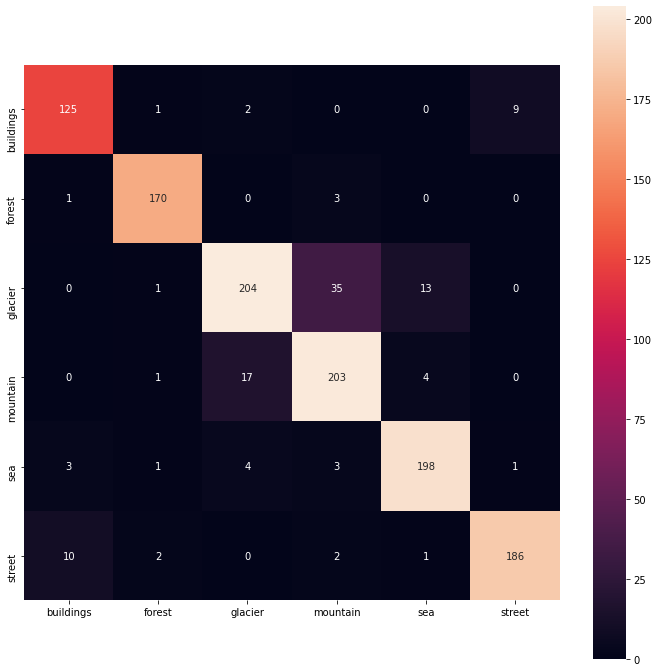

In [111]:
# Plotting confusion matrix
l = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
confusion = confusion_matrix(y_true = true_classes, y_pred = predicted_classes)
fig = plt.figure(figsize = (12, 12))
sns.heatmap(confusion, annot = True, fmt = 'd', xticklabels = l, yticklabels = l, square = True)
plt.show()